In [3]:
%matplotlib inline

# Understanding parameters of the first-level model

In this tutorial, we study how first-level models are parametrized for fMRI
data analysis and clarify the impact of these parameters on the results of the
analysis.

We use an exploratory approach, in which we incrementally include some new
features in the analysis and inspect the outcome, i.e. the resulting brain
maps.

Readers without prior experience in fMRI data analysis should first run the
`sphx_glr_auto_examples_plot_single_subject_single_run.py` tutorial to get
a bit more familiar with the base concepts, and only then run this tutorial
example.

To run this example, you must launch IPython via ``ipython --matplotlib`` in a
terminal, or use ``jupyter-notebook``.
    :depth: 1


## Retrieving the data

We use a so-called localizer dataset, which consists in a 5-minutes
acquisition of a fast event-related dataset.




In [4]:
from nilearn.datasets import func
data = func.fetch_localizer_first_level()
fmri_img = data.epi_img


Dataset created in C:\Users\yugos/nilearn_data\localizer_first_level



Downloaded 33882112 of 34532740 bytes (98.1%,    0.2s remaining) ...done. (12 seconds, 0 min)
Extracting data from C:\Users\yugos/nilearn_data\localizer_first_level\87a5dfb1630b2fce0e2fb3bdbdf6c3fe\download..... done.


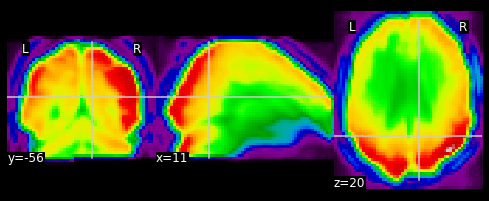

In [6]:
from nilearn.image import mean_img
from nilearn.plotting import plot_epi
plot_epi(mean_img(fmri_img))

(3.0, 3.0, 3.0, 1.0)


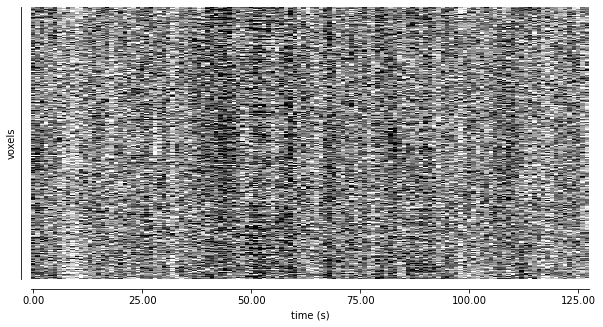

In [7]:
from nilearn.plotting import plot_carpet
display = plot_carpet(fmri_img)
import nibabel as nib
print(nib.load(fmri_img).header.get_zooms())

Define the paradigm that will be used. Here, we just need to get the provided
file.

This task, described in Pinel et al., BMC neuroscience 2007 probes basic
functions, such as button presses with the left or right hand, viewing
horizontal and vertical checkerboards, reading and listening to short
sentences, and mental computations (subractions).

Visual stimuli were displayed in four 250-ms epochs, separated by 100ms
intervals (i.e., 1.3s in total). Auditory stimuli were drawn from a recorded
male voice (i.e., a total of 1.6s for motor instructions, 1.2-1.7s for
sentences, and 1.2-1.3s for subtractions). The auditory or visual stimuli
were shown to the participants for passive listening or viewing or responses
via button presses in event-related paradigms.  Post-scan questions verified
that the experimental tasks were understood and followed correctly.

This task comprises 10 conditions:

* audio_left_hand_button_press: Left-hand three-times button press, indicated by auditory instruction
* audio_right_hand_button_press: Right-hand three-times button press, indicated by auditory instruction
* visual_left_hand_button_press: Left-hand three-times button press, indicated by visual instruction
* visual_right_hand_button_press:  Right-hand three-times button press, indicated by visual instruction
* horizontal_checkerboard: Visualization of flashing horizontal checkerboards
* vertical_checkerboard: Visualization of flashing vertical checkerboards
* sentence_listening: Listen to narrative sentences
* sentence_reading: Read narrative sentences
* audio_computation: Mental subtraction, indicated by auditory instruction
* visual_computation: Mental subtraction, indicated by visual instruction




In [17]:
t_r = 2.4
events_file = data['events']
import pandas as pd
events = pd.read_table(events_file)
events

,trial_type,onset,duration
0,visual_computation,0.000000,1.0
1,visual_computation,2.400000,1.0
2,horizontal_checkerboard,8.700000,1.0
3,audio_right_hand_button_press,11.400000,1.0
4,sentence_listening,15.000000,1.0
...,...,...,...
75,sentence_listening,284.399994,1.0
76,sentence_reading,288.000000,1.0
77,visual_right_hand_button_press,291.000000,1.0
78,sentence_listening,293.399994,1.0


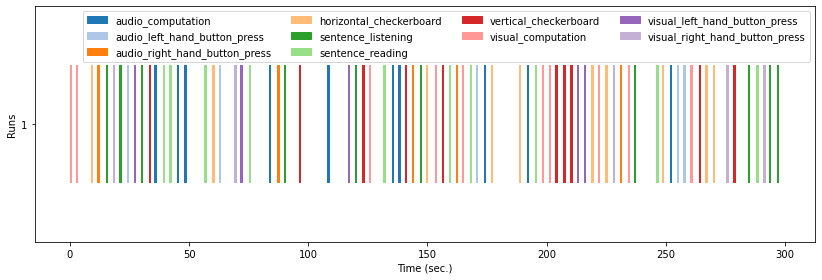

In [18]:
from nilearn.plotting import plot_event
_ = plot_event(events, figsize=(12, 4))

## Running a basic model

First we specify a linear model.
The .fit() functionality of FirstLevelModel function creates the design
matrix and the beta maps.




In [19]:
from nilearn.glm.first_level import FirstLevelModel
first_level_model = FirstLevelModel(t_r)
first_level_model = first_level_model.fit(fmri_img, events=events)
design_matrix = first_level_model.design_matrices_[0]

Let us take a look at the design matrix: it has 10 main columns corresponding
to 10 experimental conditions, followed by 3 columns describing low-frequency
signals (drifts) and a constant regressor.



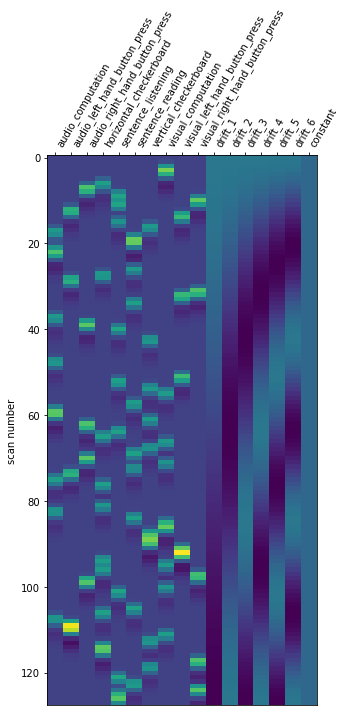

In [20]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)
import matplotlib.pyplot as plt
plt.show()

Specification of the contrasts.

For this, let's create a function that, given the design matrix, generates
the corresponding contrasts.  This will be useful to repeat contrast
specification when we change the design matrix.



In [21]:
import numpy as np

def make_localizer_contrasts(design_matrix):
    """ returns a dictionary of four contrasts, given the design matrix"""

    # first generate canonical contrasts
    contrast_matrix = np.eye(design_matrix.shape[1])
    contrasts = dict([(column, contrast_matrix[i])
                      for i, column in enumerate(design_matrix.columns)])

    contrasts['audio'] = (
        contrasts['audio_left_hand_button_press']
        + contrasts['audio_right_hand_button_press']
        + contrasts['audio_computation']
        + contrasts['sentence_listening'])

    # one contrast adding all conditions involving instructions reading
    contrasts['visual'] = (
        contrasts['visual_left_hand_button_press']
        + contrasts['visual_right_hand_button_press']
        + contrasts['visual_computation']
        + contrasts['sentence_reading'])

    # one contrast adding all conditions involving computation
    contrasts['computation'] = (contrasts['visual_computation']
                                + contrasts['audio_computation'])

    # one contrast adding all conditions involving sentences
    contrasts['sentences'] = (contrasts['sentence_listening']
                              + contrasts['sentence_reading'])

    # Short dictionary of more relevant contrasts
    contrasts = {
        'left - right button press': (
            contrasts['audio_left_hand_button_press']
            - contrasts['audio_right_hand_button_press']
            + contrasts['visual_left_hand_button_press']
            - contrasts['visual_right_hand_button_press']
        ),
        'audio - visual': contrasts['audio'] - contrasts['visual'],
        'computation - sentences': (contrasts['computation'] -
                                    contrasts['sentences']
        ),
        'horizontal-vertical': (contrasts['horizontal_checkerboard'] -
                                contrasts['vertical_checkerboard'])
    }
    return contrasts

Let's look at these computed contrasts:

* 'left - right button press': probes motor activity in left versus right button presses
* 'horizontal-vertical': probes the differential activity in viewing a horizontal vs vertical checkerboard
* 'audio - visual': probes the difference of activity between listening to some content or reading the same type of content (instructions, stories)
* 'computation - sentences': looks at the activity when performing a mental comptation task  versus simply reading sentences.




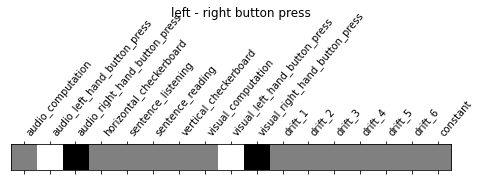

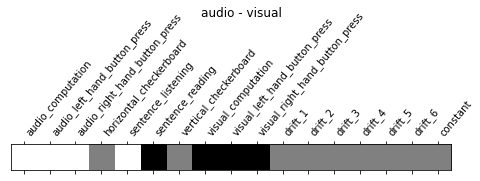

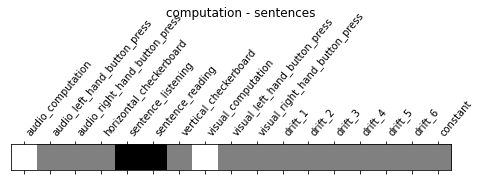

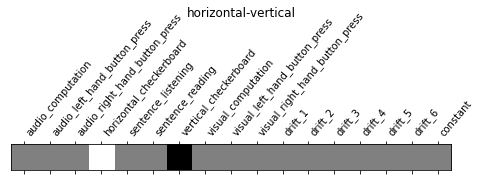

In [22]:
contrasts = make_localizer_contrasts(design_matrix)
from nilearn.plotting import plot_contrast_matrix
for key, values in contrasts.items():
    plot_contrast_matrix(values, design_matrix=design_matrix)
    plt.suptitle(key)

plt.show()

## A first contrast estimation and plotting

As this script will be repeated several times, we encapsulate model
fitting and plotting in a function that we call when needed.




In [23]:
from nilearn import plotting

def plot_contrast(first_level_model):
    """ Given a first model, specify, estimate and plot the main contrasts"""
    design_matrix = first_level_model.design_matrices_[0]
    # Call the contrast specification within the function
    contrasts = make_localizer_contrasts(design_matrix)
    fig = plt.figure(figsize=(15, 3))
    cut_coords = [66, 3, 40, 0]
    # compute the per-contrast z-map
    for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        ax = plt.subplot(1, len(contrasts), 1 + index)
        z_map = first_level_model.compute_contrast(
            contrast_val, output_type='z_score')
        plotting.plot_stat_map(
            z_map, display_mode='z', cut_coords=[cut_coords[index]], threshold=3.0, 
            title=contrast_id, axes=ax)

Let's run the model and look at the outcome.



C:\Users\yugos\anaconda3\lib\site-packages\nilearn\plotting\img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


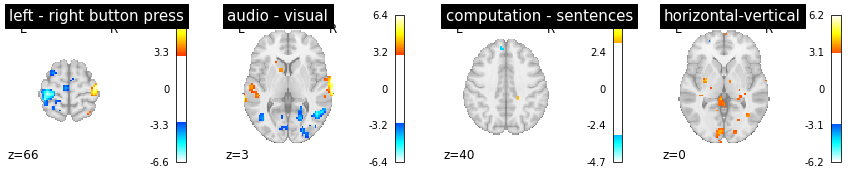

In [24]:
plot_contrast(first_level_model)
plt.show()

## Changing the hemodynamic response model

This is the filter used to convert the event sequence into a
reference BOLD signal for the design matrix. There exist different models for it, see http://nilearn.github.io/stable/auto_examples/04_glm_first_level/plot_hrf.html

The first thing that we can do is to change the default model (the
so-called Glover hrf) for the so-called canonical model of SPM
--which has a slightly weaker undershoot component.



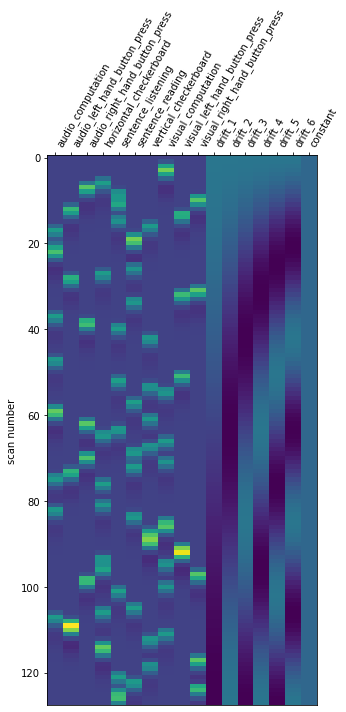

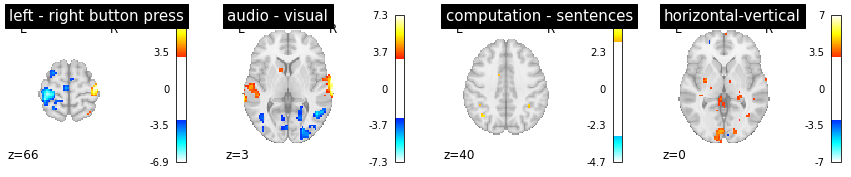

In [25]:
first_level_model = FirstLevelModel(t_r, hrf_model='spm')
first_level_model = first_level_model.fit(fmri_img, events=events)
design_matrix = first_level_model.design_matrices_[0]
plot_design_matrix(design_matrix)
plot_contrast(first_level_model)
plt.show()

No strong --positive or negative-- effect.



### Adding a time derivative to the design

There seems to be something here. Maybe we could try to go one step further:
using not only the so-called canonical hrf, but also its time derivative.
Note that in that case, we still perform the contrasts and obtain statistical
significance for the main effect --- not the time derivative. This means that
the inclusion of a time derivative in the design matrix has the sole effect
of discounting timing misspecification from the error term, which would
decrease the estimated variance and enhance the statistical significance of
the effect. Is that the case?



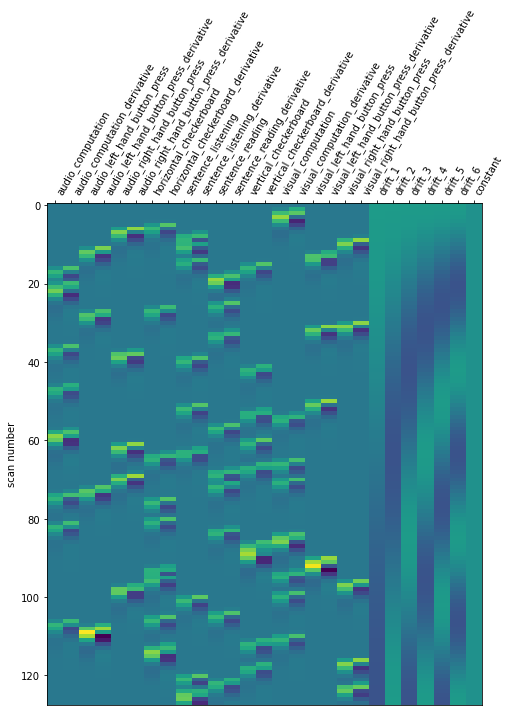

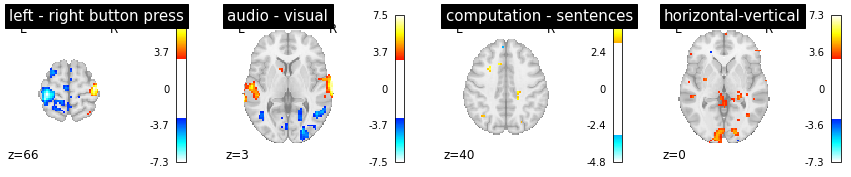

In [26]:
first_level_model = FirstLevelModel(t_r, hrf_model='spm + derivative')
first_level_model = first_level_model.fit(fmri_img, events=events)
design_matrix = first_level_model.design_matrices_[0]
plot_design_matrix(design_matrix)
plot_contrast(first_level_model)
plt.show()

Not a huge effect, but rather positive overall. We could keep that one.

Note that a benefit of this approach is that we can test which voxels are
well explained by the derivative term, hinting at misfit regions, a
possibly valuable information. This is implemented by an F-test on
the time derivative regressors.



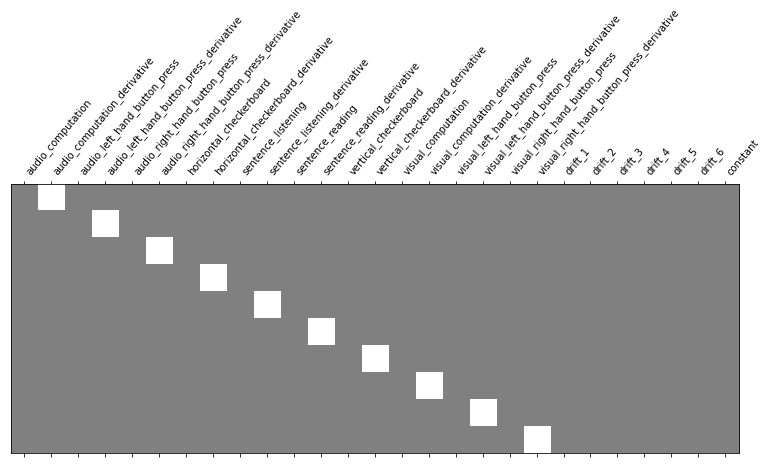

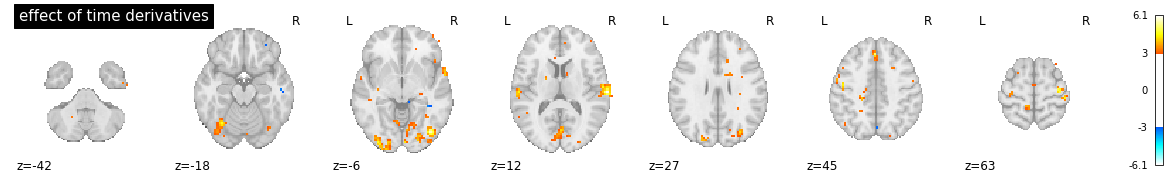

In [27]:
contrast_val = np.eye(design_matrix.shape[1])[1:21:2]
plot_contrast_matrix(contrast_val, design_matrix)

z_map = first_level_model.compute_contrast(
    contrast_val, output_type='z_score')
plotting.plot_stat_map(
    z_map, display_mode='z', threshold=3.0, title='effect of time derivatives')
plt.show()

There seems to be something here. Maybe we could adjust the
timing, by increasing the slice_time_ref parameter from 0 to 0.5. Now the
reference for model sampling is not the beginning of the volume
acquisition, but the middle of it.



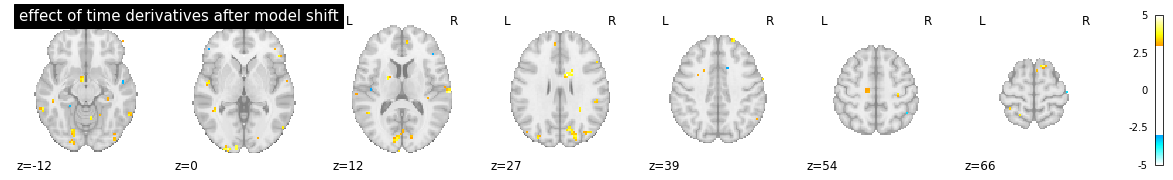

In [31]:
first_level_model = FirstLevelModel(t_r, hrf_model='spm + derivative',
                                    slice_time_ref=0.5)
first_level_model = first_level_model.fit(fmri_img, events=events)
z_map = first_level_model.compute_contrast(
    contrast_val, output_type='z_score')
plotting.plot_stat_map(
    z_map, display_mode='z', threshold=3.0,
    title='effect of time derivatives after model shift')
plt.show()

The time derivatives regressors capture less signal: it's better like that.



###  <font color="blue"> Exercise: Try with slice_time_ref = 1. Does it improve the outcome ?  </font>

We can also consider adding the so-called dispersion derivative to
capture some mis-specification in the shape of the hrf.

This is done by specifying `hrf_model='spm + derivative + dispersion'`.




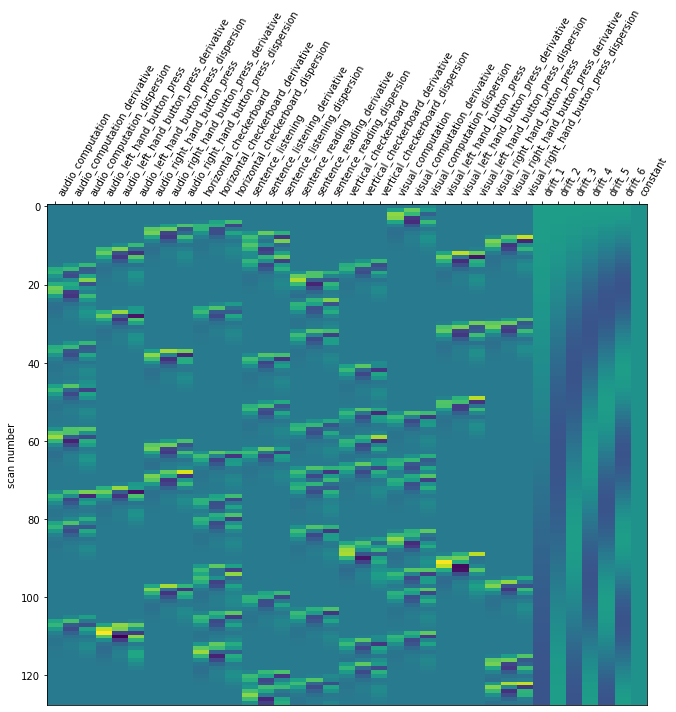

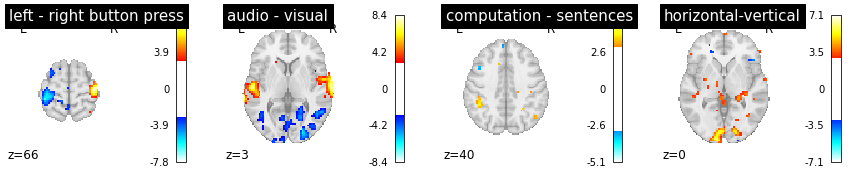

In [32]:
first_level_model = FirstLevelModel(t_r, slice_time_ref=0.5,
                                    hrf_model='spm + derivative + dispersion')
first_level_model = first_level_model.fit(fmri_img, events=events)
design_matrix = first_level_model.design_matrices_[0]
plot_design_matrix(design_matrix)
plot_contrast(first_level_model)
plt.show()

Not a huge effect. For the sake of simplicity and readability, we
can drop that one.



## The noise model: ar(1), ols, or higher order ar?

So far,we have implicitly used a lag-1 autoregressive model---aka
ar(1)---for the temporal structure of the noise. An alternative
choice is to use an ordinary least squares model (ols) that assumes
no temporal structure (time-independent noise) or
to use an autoregressive model with a higher order,
for example a third order autoregressive model---aka ar(3).

First we recompute using the `spm + derivative` hrf model, the
slice_time_ref parameter chosen above, and explicitly set
the noise model to be ar(1).



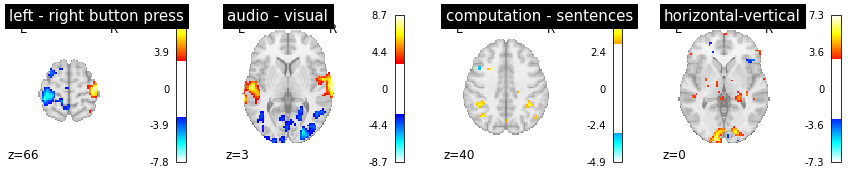

In [33]:
first_level_model = FirstLevelModel(t_r, slice_time_ref=0.5,
                                    hrf_model='spm + derivative',
                                    noise_model='ar1')
first_level_model = first_level_model.fit(fmri_img, events=events)
plot_contrast(first_level_model)
plt.show()

Next we change the noise model to ols and observe the difference
relative to the ar(1) model.



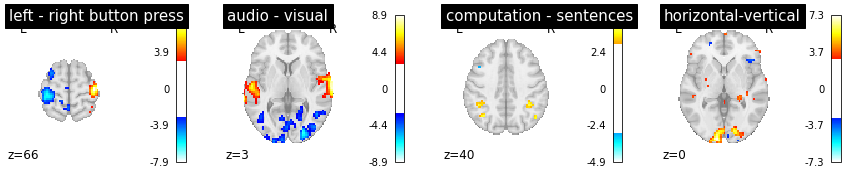

In [34]:
first_level_model = FirstLevelModel(t_r, slice_time_ref=0.5,
                                    hrf_model='spm + derivative',
                                    noise_model='ols')
first_level_model = first_level_model.fit(fmri_img, events=events)
plot_contrast(first_level_model)
plt.show()

While the difference is not obvious you should rather stick to the
ar(1) model, which is arguably more accurate.

Alternatively we can include more terms in the autoregressive model to
account for greater temporal complexity in the noise structure.



### <font color="blue"> Exercise: do the order-3 AR model (noise_model='ar3')</font>

## Removing confounds

A problematic feature of fMRI is the presence of uncontrolled
confounds in the data, due to scanner instabilities (spikes) or
physiological phenomena, such as motion, heart and
respiration-related blood oxygenation fluctuations.  Side
measurements are sometimes acquired to characterize these
effects. Here we don't have access to those.  What we can do instead
is to estimate confounding effects from the data themselves, using
the CompCor approach, and take those into account in the model.

For this we rely on the so-called `high_variance_confounds`_
routine of Nilearn.




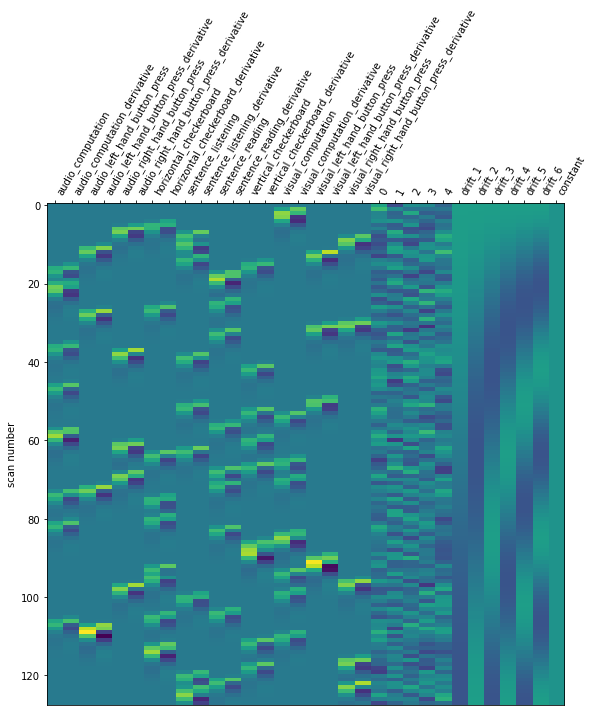

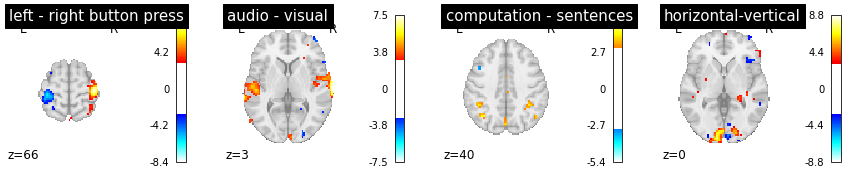

In [35]:
from nilearn.image import high_variance_confounds
confounds = pd.DataFrame(high_variance_confounds(fmri_img, percentile=1))
first_level_model = FirstLevelModel(t_r, hrf_model='spm + derivative',
                                    slice_time_ref=0.5)
first_level_model = first_level_model.fit(fmri_img, events=events,
                                          confounds=confounds)
design_matrix = first_level_model.design_matrices_[0]
plot_design_matrix(design_matrix)
plot_contrast(first_level_model)
plt.show()

Note the five additional columns in the design matrix.

The effect on the activation maps is complex: auditory/visual effects are
killed, probably because they were somewhat colinear to the confounds. On the
other hand, some of the maps become cleaner (horizontal-vertical,
computation) after this addition.



## Smoothing

Smoothing is a regularization of the model. It has two benefits:
decrease the noise level in images, and reduce the discrepancy
between individuals. The drawback is that it biases the shape and
position of activation. Here, we simply illustrate the statistical
gains.  We use a mild smoothing of 5mm full-width at half maximum
(fwhm).



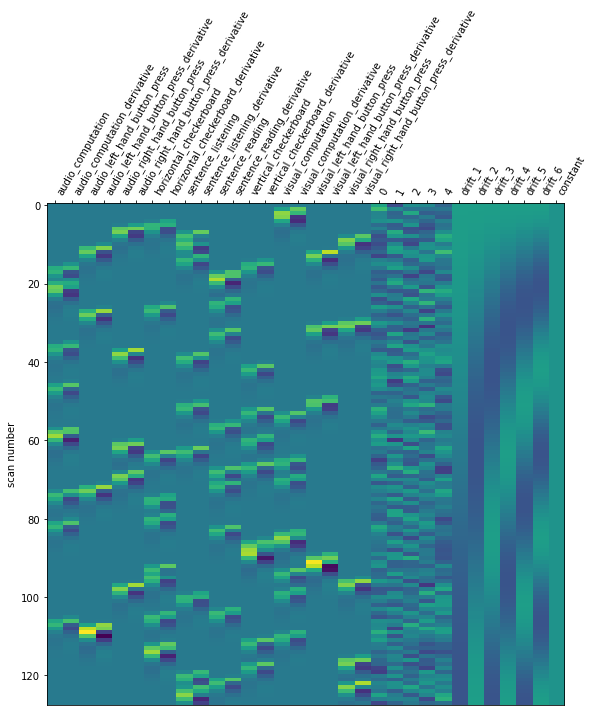

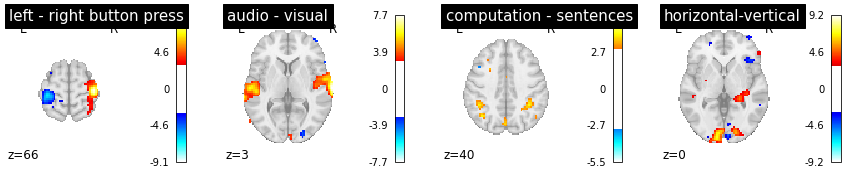

In [36]:
first_level_model = FirstLevelModel(
    t_r, hrf_model='spm + derivative', smoothing_fwhm=5,
    slice_time_ref=0.5).fit(fmri_img, events=events, confounds=confounds)
design_matrix = first_level_model.design_matrices_[0]
plot_design_matrix(design_matrix)
plot_contrast(first_level_model)
plt.show()

The design is unchanged but the maps are smoother and more contrasted.




## Masking

Masking consists in selecting the region of the image on which the
model is run: it is useless to run it outside of the brain.

The approach taken by FirstLeveModel is to estimate it from the fMRI
data itself when no mask is explicitly provided.  Since the data
have been resampled into MNI space, we can use instead a mask of the
grey matter in MNI space. The benefit is that it makes voxel-level
comparisons easier across subjects and datasets, and removes
non-grey matter regions, in which no BOLD signal is expected.  The
downside is that the mask may not fit very well this particular
data.




Dataset created in C:\Users\yugos/nilearn_data\icbm152_2009



Downloaded 57180160 of 63027871 bytes (90.7%,    0.8s remaining) ...done. (11 seconds, 0 min)
Extracting data from C:\Users\yugos/nilearn_data\icbm152_2009\6d9af5ddd5b7c892247dc9ff8f0ad351\download..... done.


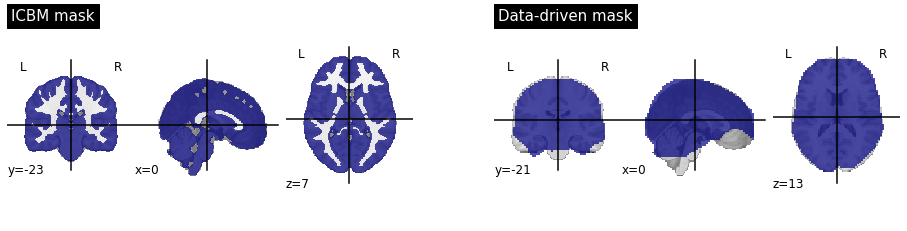

In [37]:
data_mask = first_level_model.masker_.mask_img_
from nilearn.datasets import fetch_icbm152_brain_gm_mask
icbm_mask = fetch_icbm152_brain_gm_mask()

from nilearn.plotting import plot_roi
plt.figure(figsize=(16, 4))
ax = plt.subplot(121)
plot_roi(icbm_mask, title='ICBM mask', axes=ax)
ax = plt.subplot(122)
plot_roi(data_mask, title='Data-driven mask', axes=ax)
plt.show()

For the sake of time saving, we resample icbm_mask to our data.
For this we call the resample_to_img routine of Nilearn.
We use interpolation = 'nearest' to keep the mask as a binary image.



In [39]:
from nilearn.image import resample_to_img
resampled_icbm_mask = resample_to_img(icbm_mask, data_mask,
                                      interpolation='nearest')

Impact on the first-level model.



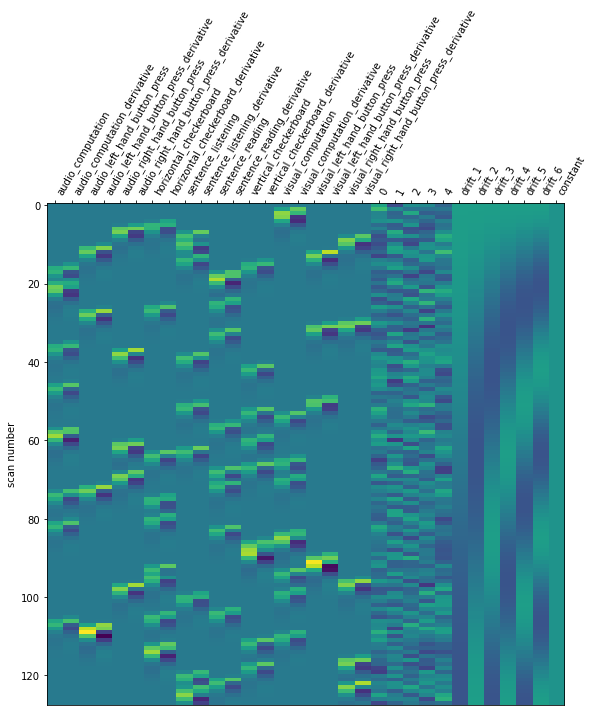

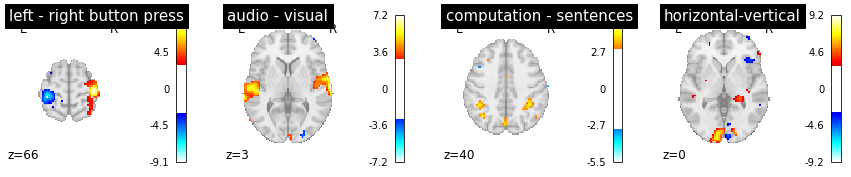

In [40]:
first_level_model = FirstLevelModel(
    t_r, hrf_model='spm + derivative', smoothing_fwhm=5, slice_time_ref=0.5,
    mask_img=resampled_icbm_mask).fit(
        fmri_img, events=events, confounds=confounds)
design_matrix = first_level_model.design_matrices_[0]
plot_design_matrix(design_matrix)
plot_contrast(first_level_model)
plt.show()

Note that it removed spurious spots in the white matter.



## Changing the drift model

The drift model is a set of slow oscillating functions
(Discrete Cosine transform) with a cut-off frequency. To remove
spurious low-frequency effects related to heart rate, breathing and
slow drifts in the scanner signal, the standard cutoff frequency
is 1/128 Hz ~ 0.01Hz. This is the default value set in the FirstLevelModel
function. Depending on the design of the experiment, the user may want to
change this value. The cutoff period (1/high_pass) should be set as the
longest period between two trials of the same condition multiplied by 2.
For instance, if the longest period is 32s, the high_pass frequency shall be
1/64 Hz ~ 0.016 Hz. Note that the design matrix has more columns to model
drifts in the data.



### <font color='blue'> Exercise: Change the drift model</font>
 
<font color='blue'> Change the drift model to a cutoff of 0.016 herz.
Then change it to None, or to an order-five polynomial "drift_model=polynomial", "drift_order=5"
What is the impact on the results ?</font>

## Conclusion

Interestingly, the model used here seems quite resilient to
manipulation of modeling parameters: this is reassuring. It shows
that Nilearn defaults ('cosine' drift, cutoff=128s, 'glover' hrf,
ar(1) model) are actually reasonable yet, could be improved upon.  
Note that these conclusions are specific to this dataset and may vary with other ones.

